In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import pystan

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [4]:
## load the data for each country
data = []
for country in ['france', 'us', 'uk', 'japan']:
    df = pd.read_csv('../data/idl_'+country+'.csv', sep=';')
    data.append(df)
data = pd.concat(data, axis=0)
data.head()

,Id,Age(years),Age(days since last birthday),Age(days),Sex,Country of birth,Country of death,Date of birth,Date of death,Validation
0,566,110,145,40321,F,FRA,FRA,25/06/1877,17/11/1987,A
1,567,111,286,40828,F,FRA,FRA,19/03/1879,30/12/1990,A
2,568,111,299,40840,F,FRA,FRA,12/02/1881,07/12/1992,A
3,569,110,53,40229,F,FRA,FRA,28/12/1881,19/02/1992,A
4,570,110,108,40285,F,FRA,FRA,18/04/1883,04/08/1993,A


In [37]:
data['yob'] = data['Date of birth'].apply(lambda x: pd.to_datetime(x).year)

In [49]:
data['yod'] = data['Date of death'].apply(lambda x: pd.to_datetime(x).year)

In [56]:
data['aod'] = data['Age(days)']/365.

(array([ 395.,   70.,   36.,   23.,    7.,    1.,    0.,    1.,    0.,    1.]),
 array([ 110. ,  111.2,  112.4,  113.6,  114.8,  116. ,  117.2,  118.4,
         119.6,  120.8,  122. ]),
 <a list of 10 Patch objects>)

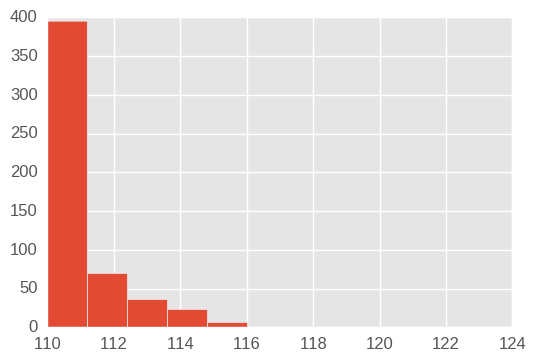

In [31]:
plt.hist(data['Age(years)'])

(array([ 293.,  146.,   52.,   32.,    8.,    0.,    1.,    1.,    0.,    1.]),
 array([ 110.07123288,  111.31726027,  112.56328767,  113.80931507,
         115.05534247,  116.30136986,  117.54739726,  118.79342466,
         120.03945205,  121.28547945,  122.53150685]),
 <a list of 10 Patch objects>)

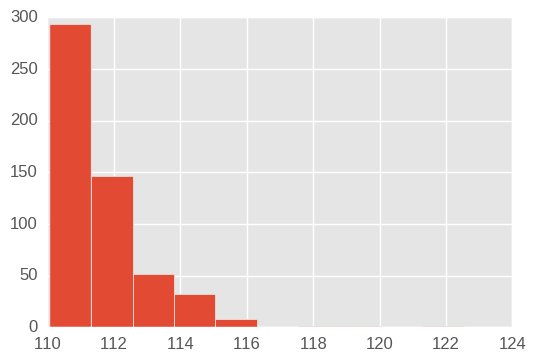

In [57]:
plt.hist(data.aod)

In [43]:
1./(data['Age(years)'].mean() - 109)

0.49674418604651183

In [48]:
data.groupby('yob')['Age(years)'].count()

yob
1856      1
1858      1
1861      1
1864      1
1867      1
1868      2
1869      1
1870      1
1871      2
1873      2
1874      1
1875      1
1877      3
1878      3
1879      2
1880      2
1881      5
1882      3
1883      7
1884     14
1885     10
1886     13
1887     13
1888     16
1889     18
1890     12
1891     13
1892     15
1893     18
1894      9
1895      2
1970    341
Name: Age(years), dtype: int64

In [50]:
data.groupby('yod')['Age(years)'].count()

yod
1968      1
1970    342
1973      1
1975      1
1978      1
1979      1
1980      1
1981      2
1982      2
1984      1
1985      1
1987      2
1988      1
1989      1
1990      4
1992      4
1993      7
1994      9
1995      4
1996      7
1997     13
1998     19
1999     18
2000     15
2001     15
2002     10
2003     14
2004     19
2005     15
2006      3
Name: Age(years), dtype: int64

In [54]:
((data.yod == 1970) & (data.yob == 1970)).sum()

341

In [55]:
data.loc[((data.yod == 1970) & (data.yob == 1970))].mean()

Id                                 395.000000
Age(years)                         110.961877
Age(days since last birthday)      164.642229
Age(days)                        40692.431085
yob                               1970.000000
yod                               1970.000000
dtype: float64

In [44]:
geom_p = 1./(data.groupby('yob')['Age(years)'].mean() - 109)

In [45]:
geom_p

yob
1856    0.500000
1858    0.500000
1861    0.333333
1864    0.500000
1867    0.500000
1868    0.666667
1869    0.333333
1870    1.000000
1871    0.666667
1873    0.333333
1874    1.000000
1875    0.076923
1877    0.300000
1878    0.600000
1879    0.333333
1880    0.400000
1881    0.500000
1882    0.500000
1883    0.500000
1884    0.341463
1885    0.384615
1886    0.371429
1887    0.650000
1888    0.592593
1889    0.500000
1890    0.571429
1891    0.520000
1892    0.468750
1893    0.620690
1894    0.642857
1895    0.666667
1970    0.509716
Name: Age(years), dtype: float64

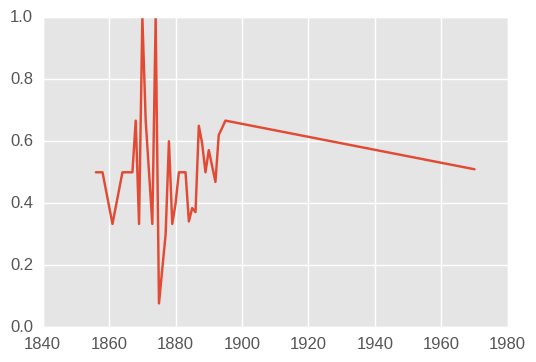

In [47]:
plt.plot(geom_p.index, geom_p)

In [111]:
%%writefile 161222_stan_beta_bounded.stan

data{
    int <lower=0> N; //number of data points
    real <lower=0> age_at_death[N]; //ages at death
}

parameters{
    real<lower=max(age_at_death),upper=1000> max_lifespan;
    real<lower=0> alpha;
    real<lower=0> beta;
}

transformed parameters{
    real<lower=0> age_transformed[N];
    for (i in 1:N){
        age_transformed[i] = age_at_death[i]/max_lifespan;
    }
}

model{
    //priors on parameters
    
    // model of age at death
    // increment directly to ensure constants are preserved
    increment_log_prob(beta_lpdf(age_transformed | alpha, beta));
}


Overwriting 161222_stan_beta_bounded.stan


In [112]:
## compile the stan model
model = pystan.StanModel(file='161222_stan_beta_bounded.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1806c09afc6168a5d60fc57510394b3c NOW.


In [113]:
model_data = {
    'N': len(data)
    , 'age_at_death': data.aod - 110
}

In [114]:
fit = model.sampling(model_data, chains=1, iter=5000)

In [115]:
fit

Inference for Stan model: anon_model_1806c09afc6168a5d60fc57510394b3c.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
max_lifespan         998.14    0.04   1.79  993.4 997.47 998.66 999.41 999.96 1887.0    1.0
alpha                   1.3  2.3e-3   0.07   1.16   1.25    1.3   1.35   1.44  898.0    1.0
beta                 843.52    1.79  55.02  738.7 806.42 843.84 877.94 959.93  943.0    1.0
age_transformed[0]   4.7e-4  1.9e-8 8.4e-7 4.7e-4 4.7e-4 4.7e-4 4.7e-4 4.7e-4 1890.0    nan
age_transformed[1]   1.9e-3  7.7e-8 3.3e-6 1.9e-3 1.9e-3 1.9e-3 1.9e-3 1.9e-3 1890.0    nan
age_transformed[2]   1.9e-3  7.8e-8 3.4e-6 1.9e-3 1.9e-3 1.9e-3 1.9e-3 1.9e-3 1890.0    nan
age_transformed[3]   2.2e-4  9.0e-9 3.9e-7 2.2e-4 2.2e-4 2.2e-4 2.2e-4 2.2e-4 1890.0    nan
age_transformed[4]   3.7e-4  1.5e-8 6.7e-7 3.7e-4 3.7e-4 3.7e-4 3.7e-4 3.7e

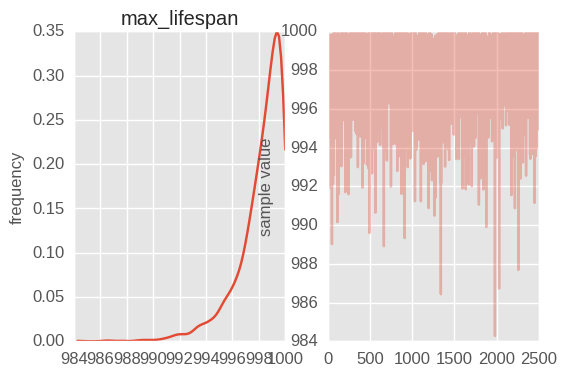

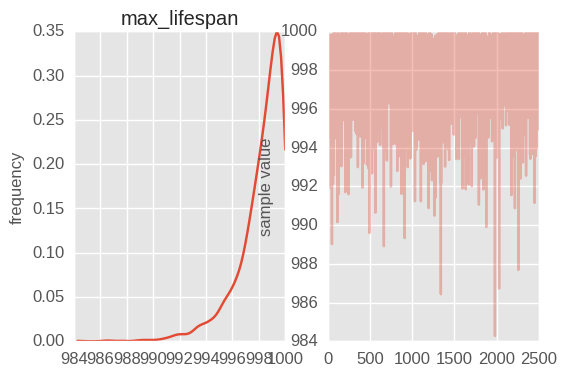

In [116]:
fit.traceplot('max_lifespan')

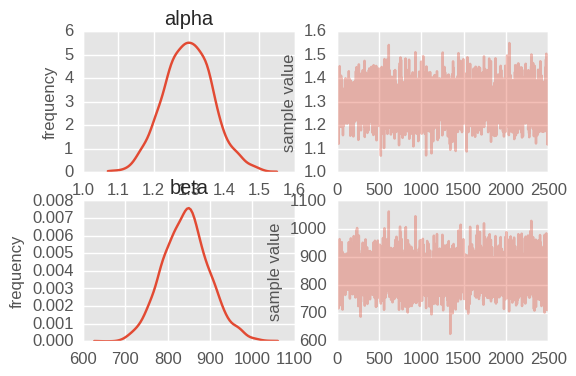

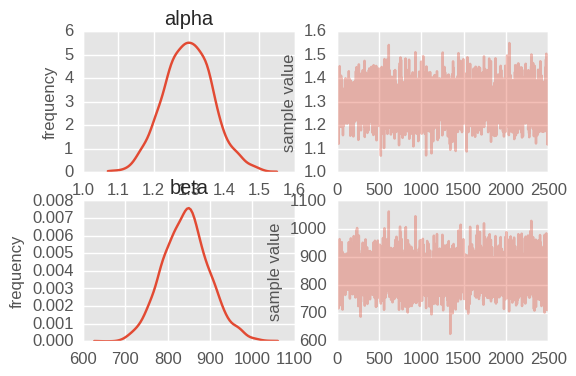

In [117]:
fit.traceplot(['alpha', 'beta'])

In [93]:
%%writefile 161222_stan_poisson.stan

data{
    int <lower=0> N; //number of data points
    int <lower=0> age_at_death[N]; //ages at death
}

parameters{
    real<lower=0> lambda;
}

model{
    //priors on parameters
    
    // model of age at death
    age_at_death ~ poisson(lambda);
}


Overwriting 161222_stan_poisson.stan


In [94]:
## compile the stan model
model_poisson = pystan.StanModel(file='161222_stan_poisson.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_268d812c6d18ddecd27aa7f21b91fee4 NOW.


In [170]:
model_data = {
    'N': len(data)
    , 'age_at_death': data['Age(years)'] - 110
}

In [171]:
fit_poisson = model_poisson.sampling(model_data, chains=1, iter=10000)

In [172]:
fit_poisson

Inference for Stan model: anon_model_268d812c6d18ddecd27aa7f21b91fee4.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   1.01  7.3e-4   0.04   0.93   0.99   1.01   1.04   1.09 3037.0    1.0
lp__   -534.3    0.01   0.62 -536.2 -534.4 -534.1 -533.9 -533.9 2253.0    1.0

Samples were drawn using NUTS at Thu Dec 22 23:22:31 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

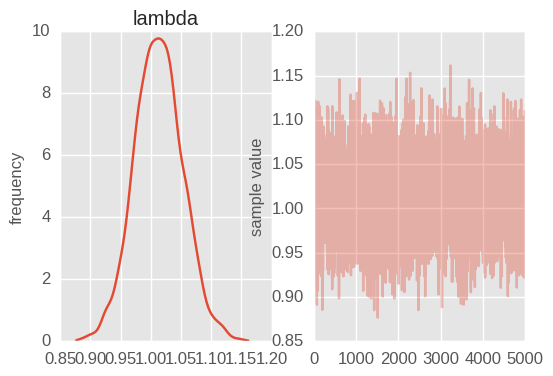

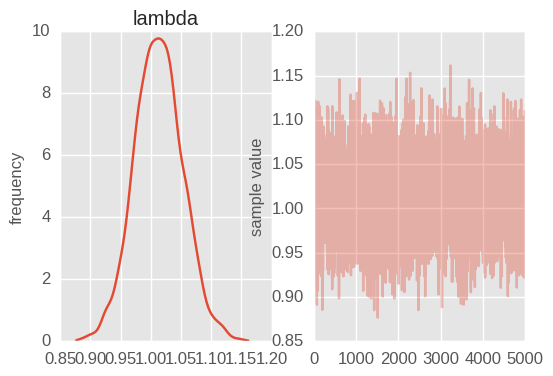

In [173]:
fit_poisson.traceplot()

In [174]:
%%writefile 161222_stan_mixture.stan

data{
    int <lower=0> N; //number of data points
    real <lower=0> age_at_death_real[N]; //ages at death
    int <lower=0> age_at_death_int[N];
}

parameters{
    //beta dist params
    real<lower=max(age_at_death_real),upper=1000> max_lifespan;
    real<lower=0> alpha;
    real<lower=0> beta;
    
    //poisson dist params
    real<lower=0,upper=1000> lambda;
    
    //mixture params
    real<lower=0,upper=1> mix;
}

transformed parameters{
    real<lower=0> age_transformed[N];
    for (i in 1:N){
        age_transformed[i] = age_at_death_real[i]/max_lifespan;
    }
}

model{
    //priors on parameters
    
    // model of age at death
    // increment directly to ensure constants are preserved
    
    vector[2] log_ps;
    log_ps[1] = log(mix) + beta_log(age_transformed, alpha, beta);
    log_ps[2] = log(1-mix) + poisson_log(age_at_death_int, lambda);
    
    increment_log_prob(log_sum_exp(log_ps));
    
}

Overwriting 161222_stan_mixture.stan


In [175]:
## compile the stan model
model_mixture = pystan.StanModel(file='161222_stan_mixture.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad469e6acf2392c2b0db77f0166ae4d3 NOW.


In [176]:
model_data = {
    'N': len(data)
    , 'age_at_death_int': data['Age(years)'] - 110
    , 'age_at_death_real': data.aod - 110
}

In [183]:
fit_mixture = model_mixture.sampling(model_data, chains=1, iter=20000)

In [184]:
fit_mixture

Inference for Stan model: anon_model_ad469e6acf2392c2b0db77f0166ae4d3.
1 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
max_lifespan         998.22    0.02   1.73 993.69 997.56 998.74 999.45 999.95 9235.0    1.0
alpha                   1.3  8.6e-4   0.07   1.17   1.25   1.29   1.34   1.43 5996.0    1.0
beta                 840.97    0.68  53.16 738.01  804.9  840.3 875.24 950.22 6186.0    1.0
lambda               504.23    2.91 281.29  31.81 265.76 506.21 742.39 973.31 9316.0    1.0
mix                    0.67  2.4e-3   0.23   0.18    0.5    0.7   0.86   0.98 9317.0    1.0
age_transformed[0]   4.7e-4  8.5e-9 8.1e-7 4.7e-4 4.7e-4 4.7e-4 4.7e-4 4.7e-4 9246.0    nan
age_transformed[1]   1.9e-3  3.4e-8 3.2e-6 1.9e-3 1.9e-3 1.9e-3 1.9e-3 1.9e-3 9246.0    nan
age_transformed[2]   1.9e-3  3.4e-8 3.3e-6 1.9e-3 1.9e-3 1.9e-3 1.9e-3 

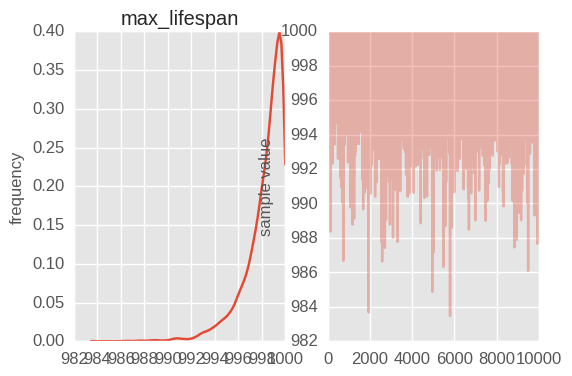

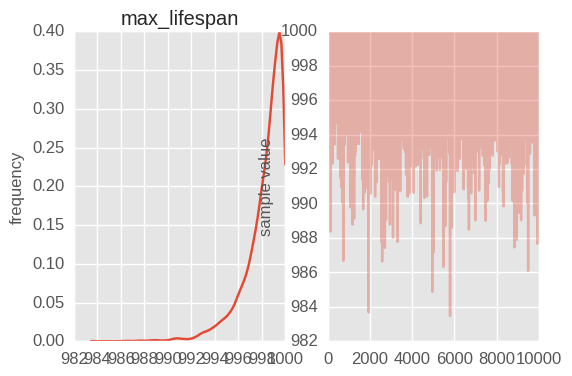

In [185]:
fit_mixture.traceplot('max_lifespan')

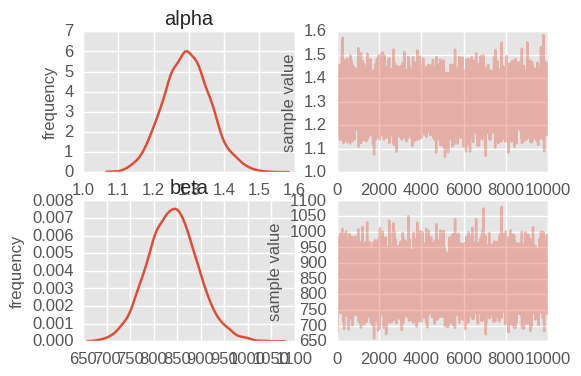

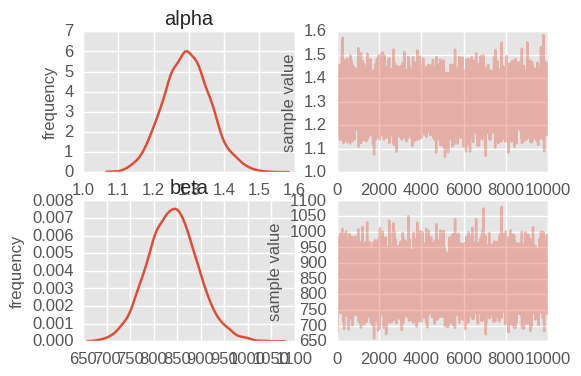

In [186]:
fit_mixture.traceplot(['alpha', 'beta'])

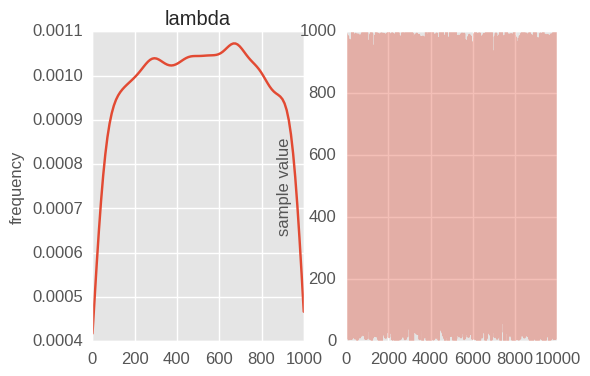

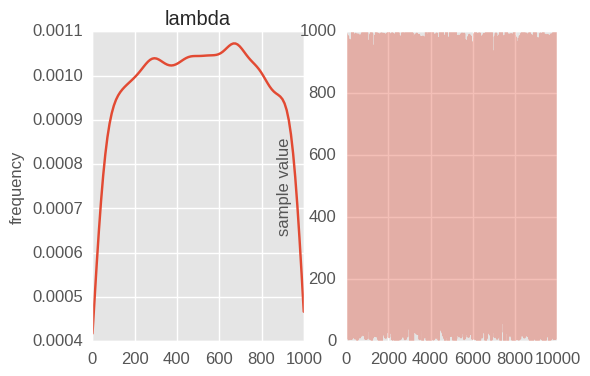

In [187]:
fit_mixture.traceplot('lambda')

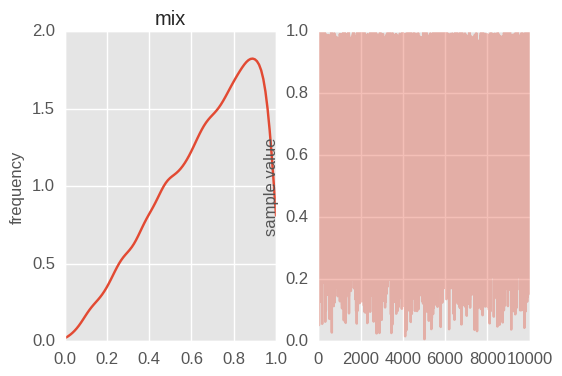

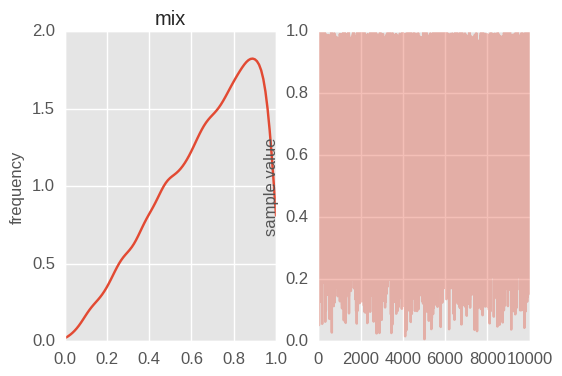

In [188]:
fit_mixture.traceplot('mix')